In [284]:
!pip install prophet

In [285]:
!pip install scikit-learn

In [286]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from prophet import Prophet
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [287]:
# Lendo CSV..
dataframe = pd.read_csv( '/content/Home.csv', low_memory=False )

dataframe

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503906,1452128306,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503907,1452128307,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503908,1452128308,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503909,1452128309,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51


In [288]:
# Somando consumo de energia de todas as cozinhas..
dataframe['KW_kitchen'] = dataframe['Kitchen 12 [kW]'] + dataframe['Kitchen 14 [kW]'] + dataframe['Kitchen 38 [kW]']

In [289]:
# Renomeando colunas..
dataframe.rename( columns={
      'temperature': 'C_temperature',
      'use [kW]': 'KW_use',
      'Home office [kW]': 'KW_home_office',
      'Living room [kW]': 'KW_living_room',
      'Wine cellar [kW]': 'KW_wine_cellar',
      'Garage door [kW]': 'KW_garage_door',
      'Barn [kW]': 'KW_barn'
    }, 
    inplace=True 
)

In [290]:
format_date = '%Y-%m-%d %H:%M:%S'

initial_date = time.strftime( format_date, time.localtime( int( dataframe.loc[0, 'time'] ) ) )
index = pd.date_range( initial_date, periods=len( dataframe ), freq='min' )
dataframe = dataframe.set_index( pd.DatetimeIndex( data=index, name='datetime' ) ).groupby( pd.Grouper( freq='min' ) ).mean()

dataframe.tail()

,KW_use,gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],KW_home_office,Fridge [kW],KW_wine_cellar,KW_garage_door,...,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,KW_kitchen
datetime,,,,,,,,,,,,,,,,,,,,,
2016-12-16 03:26:00,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.00060
2016-12-16 03:27:00,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.00060
2016-12-16 03:28:00,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.00065
2016-12-16 03:29:00,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,0.012833,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.00065
2016-12-16 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
# Removendo Nan e Null..
dataframe = dataframe.dropna()

In [292]:
# Removendo colunas que não serão utilizadas..
del dataframe['House overall [kW]']
del dataframe['apparentTemperature']
del dataframe['Solar [kW]']
del dataframe['humidity']
del dataframe['visibility']
del dataframe['pressure']
del dataframe['windSpeed']
del dataframe['windBearing']
del dataframe['precipIntensity']
del dataframe['dewPoint']
del dataframe['precipProbability']

# Removendo colunas de eletrodomésticos..
del dataframe['gen [kW]']
del dataframe['Dishwasher [kW]']
del dataframe['Furnace 1 [kW]']
del dataframe['Furnace 2 [kW]']
del dataframe['Fridge [kW]']
del dataframe['Well [kW]']
del dataframe['Microwave [kW]']

# Deletando colunas com nomes antigos..
del dataframe['Kitchen 12 [kW]']
del dataframe['Kitchen 14 [kW]']
del dataframe['Kitchen 38 [kW]']

dataframe

,KW_use,KW_home_office,KW_wine_cellar,KW_garage_door,KW_barn,KW_living_room,C_temperature,KW_kitchen
datetime,,,,,,,,
2016-01-01 05:00:00,0.932833,0.442633,0.006983,0.013083,0.031350,0.001517,36.14,0.000567
2016-01-01 05:01:00,0.934333,0.444067,0.006983,0.013117,0.031500,0.001650,36.14,0.000567
2016-01-01 05:02:00,0.931817,0.446067,0.006983,0.013083,0.031517,0.001650,36.14,0.000617
2016-01-01 05:03:00,1.022050,0.446583,0.006983,0.013000,0.031500,0.001617,36.14,0.000650
2016-01-01 05:04:00,1.139400,0.446533,0.006850,0.012783,0.031500,0.001583,36.14,0.000783
...,...,...,...,...,...,...,...,...
2016-12-16 03:25:00,1.601233,0.041783,0.008667,0.013483,0.032283,0.000967,35.12,0.000633
2016-12-16 03:26:00,1.599333,0.041750,0.008433,0.013433,0.032200,0.000933,35.12,0.000600
2016-12-16 03:27:00,1.924267,0.042033,0.008467,0.012933,0.032283,0.001000,35.12,0.000600


In [293]:
# Reposicionando colunas..
dataframe = dataframe[['C_temperature', 'KW_use', 'KW_kitchen', 'KW_living_room', 'KW_home_office', 'KW_wine_cellar', 'KW_barn', 'KW_garage_door']]

dataframe

,C_temperature,KW_use,KW_kitchen,KW_living_room,KW_home_office,KW_wine_cellar,KW_barn,KW_garage_door
datetime,,,,,,,,
2016-01-01 05:00:00,36.14,0.932833,0.000567,0.001517,0.442633,0.006983,0.031350,0.013083
2016-01-01 05:01:00,36.14,0.934333,0.000567,0.001650,0.444067,0.006983,0.031500,0.013117
2016-01-01 05:02:00,36.14,0.931817,0.000617,0.001650,0.446067,0.006983,0.031517,0.013083
2016-01-01 05:03:00,36.14,1.022050,0.000650,0.001617,0.446583,0.006983,0.031500,0.013000
2016-01-01 05:04:00,36.14,1.139400,0.000783,0.001583,0.446533,0.006850,0.031500,0.012783
...,...,...,...,...,...,...,...,...
2016-12-16 03:25:00,35.12,1.601233,0.000633,0.000967,0.041783,0.008667,0.032283,0.013483
2016-12-16 03:26:00,35.12,1.599333,0.000600,0.000933,0.041750,0.008433,0.032200,0.013433
2016-12-16 03:27:00,35.12,1.924267,0.000600,0.001000,0.042033,0.008467,0.032283,0.012933


In [294]:
#Generating the data per day
energy_per_day = dataframe.resample('D').sum()
energy_per_day

,C_temperature,KW_use,KW_kitchen,KW_living_room,KW_home_office,KW_wine_cellar,KW_barn,KW_garage_door
datetime,,,,,,,,
2016-01-01,40727.34,1366.269517,11.619833,77.071667,64.668783,29.093367,99.622950,15.228367
2016-01-02,45637.30,1851.521067,15.464256,71.142950,145.570317,24.096767,185.776967,19.246333
2016-01-03,47914.02,1651.128133,19.092004,42.779250,196.064167,32.989533,146.493667,19.444933
2016-01-04,32108.72,1500.686017,17.346254,93.077467,180.650867,20.980700,47.837017,19.249983
2016-01-05,17208.20,1597.968867,14.754489,44.483650,133.360867,30.792300,50.166067,19.773067
...,...,...,...,...,...,...,...,...
2016-12-12,63213.12,1617.835017,10.675023,124.287683,59.676483,40.523333,47.439633,22.473050
2016-12-13,51200.39,1133.408117,10.267541,85.476550,59.511567,30.369767,48.607150,19.151850
2016-12-14,43147.14,1026.850250,5.734158,52.031633,59.465533,39.065917,48.728567,21.250750


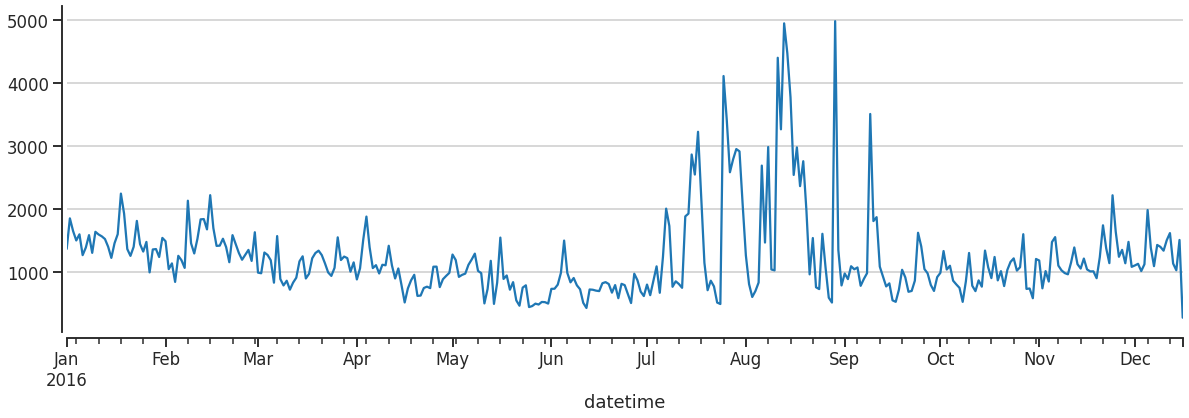

In [295]:
ig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

energy_per_day['KW_use'].plot(ax=ax)
ax.yaxis.grid(True)
sns.despine(offset=5, trim=False)

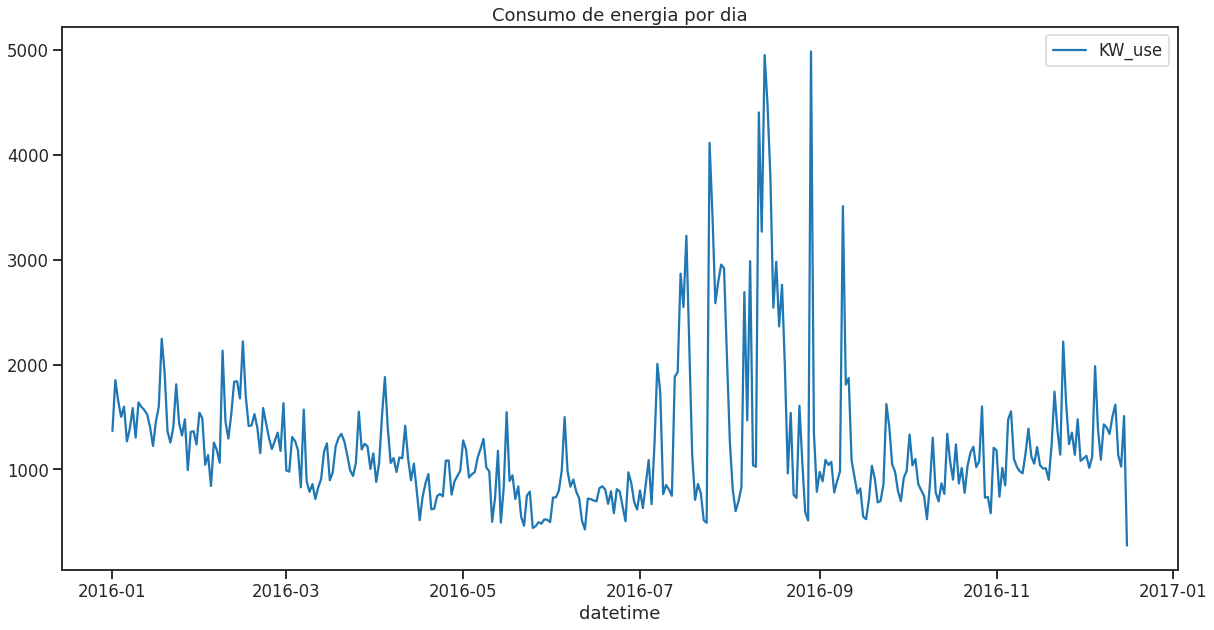

In [296]:
# Set the width and height of the figure
plt.figure(figsize=(20,10))

# Add title
plt.title("Consumo de energia por dia")
#Plotting the energy consumption per day
sns.lineplot(data = energy_per_day.filter(items=['KW_use']), dashes=False)


In [297]:
#Pegando apenas a coluna de consumo 
energy_per_day = energy_per_day['KW_use']
energy_per_day

datetime
2016-01-01    1366.269517
2016-01-02    1851.521067
2016-01-03    1651.128133
2016-01-04    1500.686017
2016-01-05    1597.968867
                 ...     
2016-12-12    1617.835017
2016-12-13    1133.408117
2016-12-14    1026.850250
2016-12-15    1508.666433
2016-12-16     273.442767
Freq: D, Name: KW_use, Length: 351, dtype: float64

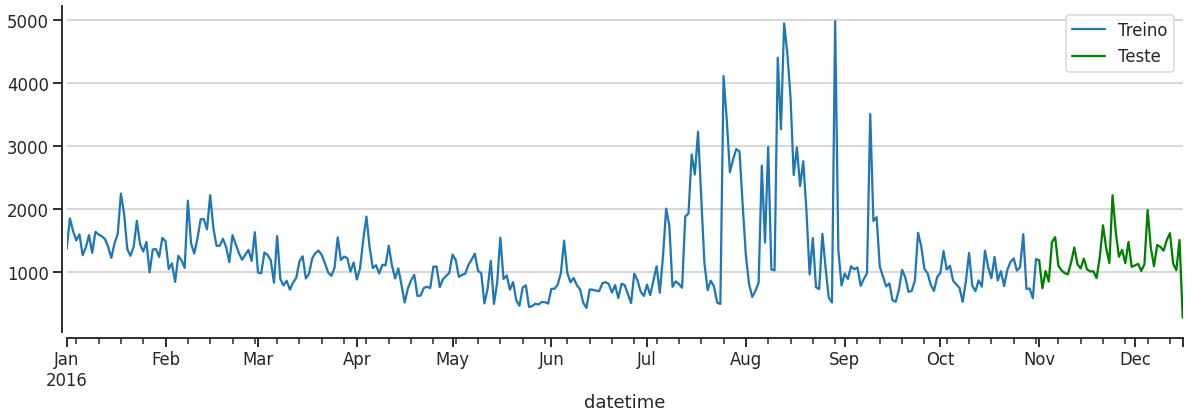

In [298]:
train = energy_per_day["2016-01-01":"2016-11-01"]
test = energy_per_day["2016-11-01":]

fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [299]:
train_prophet = train.reset_index().rename(columns={'datetime': 'ds', 'KW_use': 'y'})
train_prophet

,ds,y
0,2016-01-01,1366.269517
1,2016-01-02,1851.521067
2,2016-01-03,1651.128133
3,2016-01-04,1500.686017
4,2016-01-05,1597.968867
...,...,...
301,2016-10-28,730.695083
302,2016-10-29,736.967000
303,2016-10-30,582.650200
304,2016-10-31,1206.498950


In [300]:
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [301]:
future = model.make_future_dataframe(periods=182, freq = 'D')
forecast = model.predict(future)

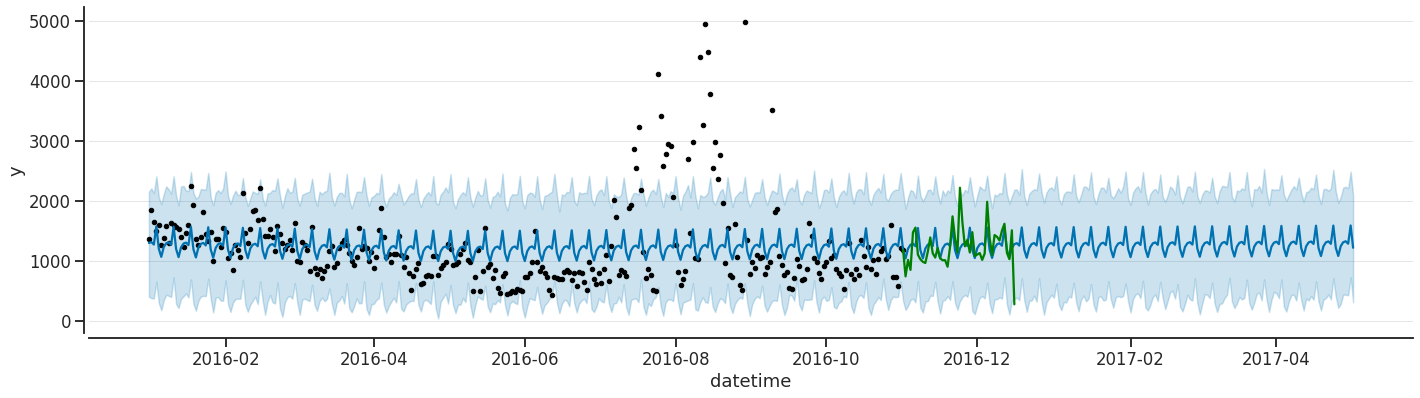

In [302]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [319]:
model = Prophet(yearly_seasonality=28, seasonality_mode="multiplicative")
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [320]:
future = model.make_future_dataframe(periods=182, freq="D")
forecast = model.predict(future)

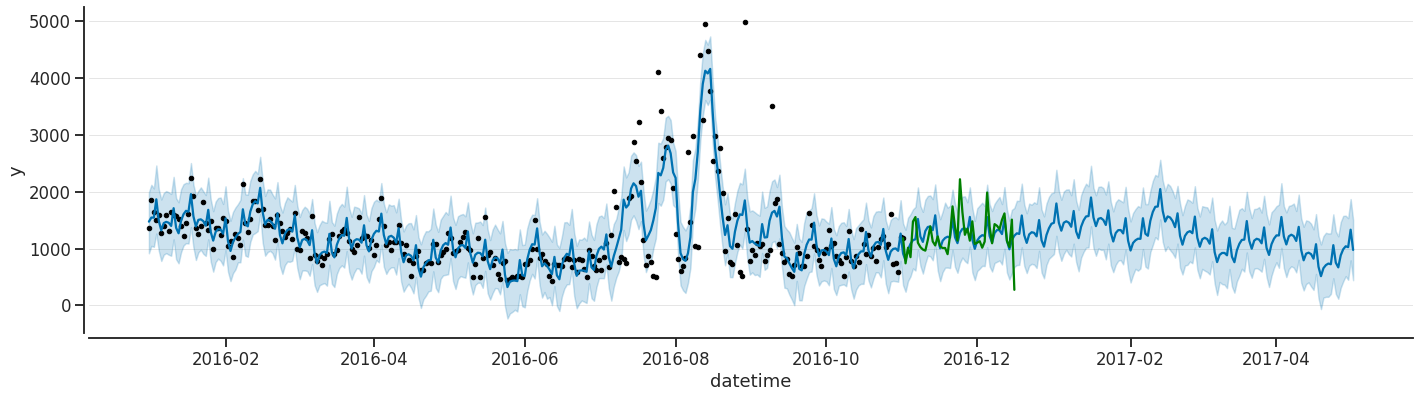

In [321]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)